<a href="https://colab.research.google.com/github/Matteo-Candi/Fine-Tuning-with-LoRA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [11]:
%pip install datasets

In [12]:
from transformers import set_seed, BertTokenizer, TFBertModel, TFBertForSequenceClassification
from datasets import load_dataset, concatenate_datasets
import tensorflow as tf
import keras

from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import math

In [13]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

# Dataset

In [476]:
dataset = load_dataset("go_emotions", "simplified").shuffle(seed=17)
labels = dataset['train'].features['labels'].feature.names
dataset = dataset.remove_columns('id')


def filter_labels(example):
    return len(example['labels']) < 2

for split in dataset.keys():
    dataset[split] = dataset[split].filter(filter_labels)

model_name = "bert-base-cased"
num_labels = 28

tokenizer = BertTokenizer.from_pretrained(model_name)

In [477]:
def get_df_summary(df):
    label_column = df['labels'].to_list()
    flatten_col = list(itertools.chain(*label_column))
    freq_dict = dict(Counter(flatten_col))
    freq_list = list(dict(sorted(freq_dict.items())).values())
    rel_freq_list = [el / sum(freq_list) * 100 for el in freq_list]

    return rel_freq_list

In [478]:
df_train = dataset['train'].to_pandas()
df_val = dataset['validation'].to_pandas()
df_test = dataset['test'].to_pandas()

# Get dataframes info.
train_freq = get_df_summary(df_train)
val_freq = get_df_summary(df_val)
test_freq = get_df_summary(df_test)

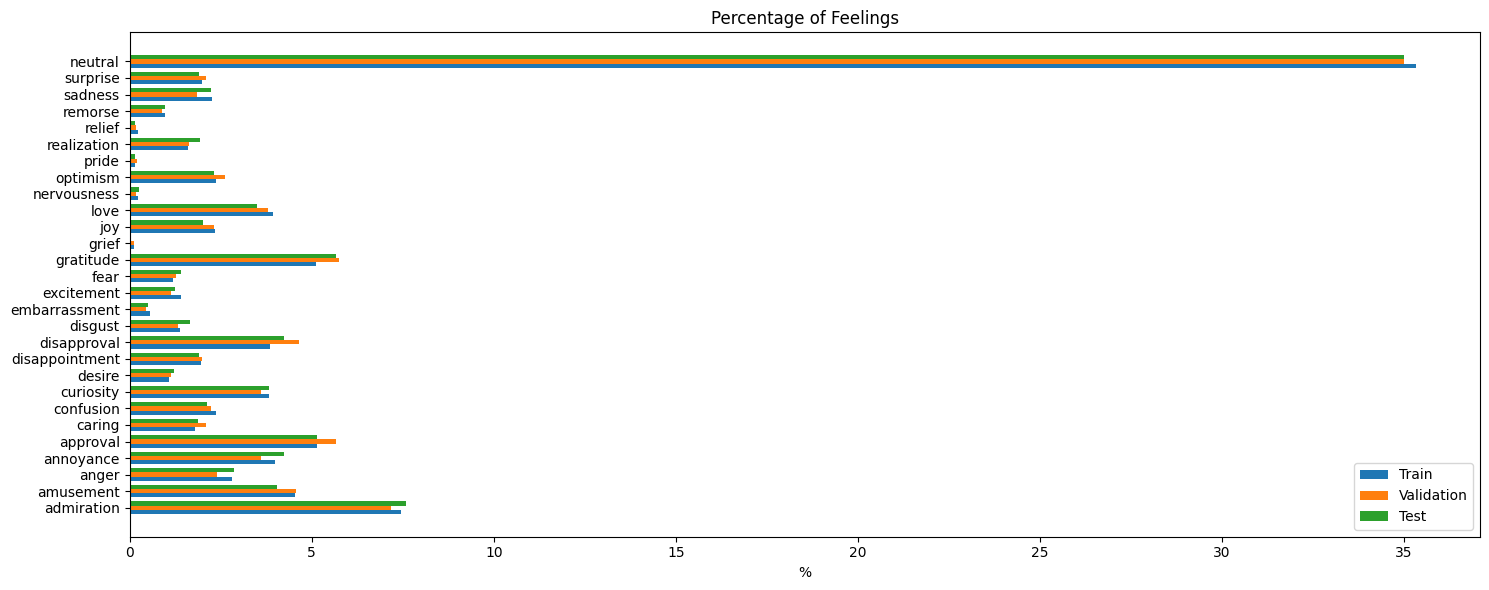

In [479]:
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.25
index = np.arange(len(train_freq))
bars_train = ax.barh(index, train_freq, bar_width, label='Train')
bars_val = ax.barh(index + bar_width, val_freq, bar_width, label='Validation')
bars_test = ax.barh(index + 2*bar_width, test_freq, bar_width, label='Test')
plt.xlabel('%')
plt.title('Percentage of Feelings')
plt.yticks(index + bar_width, labels)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def tokenizer_func(text):
    '''
    Tokenizing the text using the BERT tokenizer.
    '''
    # Checking there is just one tokenization up to 316 and the second longest one is 120.
    # token_lengths = [sum(tokenized_train[i][0] != 0) for i in range(len(tokenized_train))]
    return tokenizer(text, padding = 'max_length', max_length = 120, return_tensors = "tf", truncation=True)

def one_hot_func(indices):
    '''
    Converting a value in one hot encode vector.
    '''
    one_hot_encoding = np.zeros(28, dtype=int)
    one_hot_encoding[indices] = 1
    return {'labels': one_hot_encoding}

def process_dataset_func(dataset):
    '''
    Processing the dataset to make it readable from the model.
    '''
    processed_dataset = dataset.map(lambda x: tokenizer_func(x['text']))
    processed_dataset = processed_dataset.map(lambda x: one_hot_func(x['labels']))
    processed_dataset = processed_dataset.remove_columns('text')
    return processed_dataset

In [ ]:
dataset = process_dataset_func(dataset)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
batch_size = 32
tf_dataset_train = tf.data.Dataset.from_tensor_slices((dataset['train']['input_ids'], dataset['train']['labels'])).batch(batch_size)
tf_dataset_validation = tf.data.Dataset.from_tensor_slices((dataset['validation']['input_ids'], dataset['validation']['labels'])).batch(batch_size)
tf_dataset_test = tf.data.Dataset.from_tensor_slices((dataset['test']['input_ids'], dataset['test']['labels'])).batch(batch_size)

# Reshape labels to match the model output.
tf_dataset_train = tf_dataset_train.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))
tf_dataset_validation = tf_dataset_validation.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))
tf_dataset_test = tf_dataset_test.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))

# Models

## Base model

In [319]:
pretrained_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = num_labels)
pretrained_model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_242 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  21532     
                                                                 
Total params: 108331804 (413.25 MB)
Trainable params: 108331804 (413.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
class BaseModel(tf.keras.Model):
    def __init__(self, model_name, num_labels):
        super(BaseModel, self).__init__()
        self.num_labels = num_labels

        # When importing the model some weigths have different initialization states.
        set_seed(17)
        self.model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = self.num_labels)
        self.softmax = tf.keras.layers.Activation('softmax')


    def call(self, input):

        # The model detect automatically 'input_ids' and 'attention_mask'.
        logits = self.model(input)[0]
        model_output = self.softmax(logits)

        return model_output

In [ ]:
stop

In [ ]:
base_model = BaseModel(model_name, num_labels, threshold = .3)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

base_model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

num_epochs = 5

base_model_history = base_model.fit(tf_dataset_train, validation_data=tf_dataset_validation, epochs=num_epochs, batch_size=batch_size)

In [ ]:
base_model_history.history

{'loss': [0.1308445781469345],
 'accuracy': [0.4223450720310211],
 'val_loss': [0.09471436589956284],
 'val_accuracy': [0.5379653573036194]}

## Model fine-tuned with LoRA

In [532]:
pretrained_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = num_labels)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [531]:
class LoraLayer(keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        rank=8,
        alpha=32,
        trainable=True,
        **kwargs,
    ):
        # We want to keep the name of this layer the same as the original
        # dense layer.
        original_layer_config  = original_layer.get_config()
        name = original_layer_config['name']

        super().__init__(name=name, trainable=trainable, **kwargs)

        self.rank = rank
        self.alpha = alpha

        self._scale = alpha / rank
        self._hidden_dim = original_layer_config['units']

        # Layers.

        # Original dense layer.
        self.original_layer = original_layer
        self.original_layer.trainable = False

        # LoRA dense layers.
        self.A = keras.layers.Dense(
            units=rank,
            use_bias=False,
            # Note: the original paper mentions that normal distribution was
            # used for initialization. However, the official LoRA implementation
            # uses "Kaiming/He Initialization".
            kernel_initializer=keras.initializers.VarianceScaling(
                scale=math.sqrt(5), mode="fan_in", distribution="uniform"
            ),
            trainable=trainable,
            name="lora_A",
        )

        self.B = keras.layers.EinsumDense(
            equation='ab,bc->ac',
            output_shape=original_layer_config["units"],
            kernel_initializer="zeros",
            trainable=trainable,
            name="lora_B",
        )


    # def build(self, input_shape=None):
    #     if self.built:
    #         return
    #     self.built = True
    #     if getattr(self, "lora_A", None) is not None:
    #         with tf.name_scope(self.A.name):
    #             self.A.build([None, None, self._hidden_dim])

    def call(self, inputs):
        original_output = self.original_layer(inputs)
        if self.trainable:
            # If we are fine-tuning the model, we will add LoRA layers' output
            # to the original layer's output.
            lora_output = self.B(self.A(inputs)) * self._scale
            return original_output + lora_output

        # If we are in inference mode, we "merge" the LoRA layers' weights into
        # the original layer's weights - more on this in the text generation
        # section!
        return original_output



In [533]:
# Add the LoRa layers to all the Attention layers.
for i in range(12):
    feed_forward_layer = pretrained_model.bert.encoder.layer[i].attention.dense_output.dense
    pretrained_model.bert.encoder.layer[i].attention.dense_output.dense = LoraLayer(feed_forward_layer, trainable = True)

In [537]:
for layer in pretrained_model.layers:
    if layer.name == 'bert':
        for sublayer in layer.submodules:
            if sublayer.name not in ['lora_A', 'lora_B']:
                sublayer.trainable = False
            else:
                sublayer.trainable = True
                # sublayer.build((32, 768))
                print(sublayer.name, sublayer.count_params())

    else:
        layer.trainable = False

lora_A 6144
lora_B 589824
lora_A 6144
lora_B 589824
lora_A 6144
lora_B 589824
lora_A 6144
lora_B 589824
lora_A 6144
lora_B 589824
lora_A 6144
lora_B 589824
lora_A 6144
lora_B 589824
lora_A 6144
lora_B 589824
lora_A 6144
lora_B 589824
lora_A 6144
lora_B 589824
lora_A 6144
lora_B 589824
lora_A 6144
lora_B 589824


In [538]:
589824 / 6144

96.0

In [535]:
pretrained_model.summary()

Model: "tf_bert_for_sequence_classification_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_1268 (Dropout)      multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  21532     
                                                                 
Total params: 108331804 (413.25 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 108331804 (413.25 MB)
_________________________________________________________________


In [ ]:
108331804

In [179]:
pretrained_model.bert.encoder.layer[0].attention.dense_output.dense = tf.keras.layers.Dense(units=768)

Sources:
- [Multi class with Bert](https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi-Class%20classification%20TF-BERT/multi_class.ipynb)
- [Dataset Preprocessing](https://huggingface.co/docs/datasets/v1.12.1/use_dataset.html)
- [LoRA Layer and injection](https://github.com/keras-team/keras-io/blob/master/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora.py)

In [235]:
def get_ff_attention_weights(model):
    kernel_initial_weights = []
    bias_initial_weights = []
    for weights in model.layers[0].weights:
        if 'attention/output/dense/' in weights.name:
            if 'kernel' in weights.name:
                kernel_initial_weights.append(weights)
            elif 'bias' in weights.name:
                bias_initial_weights.append(weights)

    return kernel_initial_weights, bias_initial_weights


kernel_initial_weights, bias_initial_weights = get_ff_attention_weights(pretrained_model)
hidden_size = pretrained_model.bert.encoder.layer[0].attention.dense_output.config.hidden_size
kernel_initializer = pretrained_model.bert.encoder.layer[0].attention.dense_output.config.initializer_range